Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [19]:
WELLS = ["CCS1", "VW1"]        #wells being used
EPOCHS = 10                   #number of iterations picking batch worth of sequences
BATCH_SIZE = 32                #how much data you pass in at once
LR = 0.001                     #learning rate
FRAC_THRESHOLD = 0.2           #probability needed to qualify a fracture

FORMATIONS = [                 #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"
MODEL_DUMP_PATH = "REU Project/Models/FFNN/"

Imports

In [20]:
import numpy as np
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, \
accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import time
import matplotlib.pyplot as plt
import math
import pandas as pd
import joblib
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

Retrieve Data and Labels

In [21]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

CCS1 : Shape of inputs= (4217, 24)
CCS1 : Shape of labels= (4217, 2)
CCS1 : Shape of merged= (4217, 25)
VW1 : Shape of inputs= (3999, 24)
VW1 : Shape of labels= (3999, 2)
VW1 : Shape of merged= (3999, 25)
Num features: 22


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [22]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [23]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [24]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes:\
  {new_X_train.shape}, {new_X_test.shape}")
  return new_X_train, new_X_test

Result Evaluation Tools

In [25]:
def plot_train_test_loss(training_losses, testing_losses):
  """
  Plots loss over epochs.
  """
  plt.plot(training_losses, label = "training losses")
  plt.plot(testing_losses, label = "testing losses")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [26]:
def plot_depth_probabilities(curr_well, depths, y_pred, y_pred_rounded):
  """
  Plots predicted probability of a fracture at each depth.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth")
  plt.title(curr_well + " Predictions")
  plt.barh(depths, y_pred, color="red", label="Probability")
  plt.barh(depths, y_pred_rounded, color="blue", label="Rounded")
  plt.xlim(-0.1,1.1)
  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.gca().invert_yaxis()
  plt.legend()
  plt.show()

In [27]:
def plot_depths_with_labels(curr_well, ds, y_pred_rounded, test_labels):
  """
  Plots the depths that are predicted to contain fractures (have a probability
  greather than THRESHOLD) alongside the actual depths that contain fractures.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]", fontsize = "large")
  plt.title(curr_well + "(Predictions | Truth)")
  y_pred_rounded = [-1 * y for y in y_pred_rounded]
  plt.barh(ds, y_pred_rounded, color="blue")
  plt.barh(ds, test_labels, color="gray")
  mind = math.floor(int(ds.min()) / 250) * 250
  maxd = math.floor(int(ds.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  plt.gca().invert_yaxis()
  #plt.savefig(curr_well + '_FFNNplot.png', format='png', dpi=1200)
  plt.show()

In [28]:
def evaluate_performance(curr_well, dataset,
                        show_precision_recall_numfracs = False, test_depths=[]):
  """
  Passes dataset through model and prints metrics indicating its performance.
  """
  model = joblib.load(MODEL_DUMP_PATH + curr_well + ".joblib")
  y_trues = []
  y_preds = []
  y_preds_rounded = []
  with torch.no_grad():
      for data, labels in dataset:
          y_pred = model(data) #pass data through the model
          y_preds.extend([item[0] for item in y_pred.tolist()])
          y_trues.extend([item for item in labels.tolist()])

  #normalize ys
  y_pred_max = max(max(y_preds), 1)
  for i in range(len(y_preds)):
    y_preds[i] = max(0, (y_preds[i] / y_pred_max))

  #set a threshold for what is qualified as a fracture
  y_pred_rounded = []
  for y in y_preds:
    if y > FRAC_THRESHOLD:
      y_pred_rounded.append(1)
    else:
      y_pred_rounded.append(0)

  #print metrics
  if show_precision_recall_numfracs:
    print(f"Predicted num fractured depths: {sum(y_pred_rounded)},\
    true num fractured depths: {sum(y_trues)}")
  accuracy = accuracy_score(y_trues, y_pred_rounded)
  print(f"Accuracy = {round((accuracy * 100), 2)}%")
  if show_precision_recall_numfracs:
    precision = precision_score(y_trues, y_pred_rounded, average="macro")
    recall = recall_score(y_trues, y_pred_rounded, average="macro")
    print(f"Precision = {(precision * 100).round(2)}%")
    print(f"Recall = {(recall * 100).round(2)}%")
  f1 = f1_score(y_trues, y_pred_rounded, average="macro")
  print(f"F1 = {(f1 * 100).round(2)}%")

  #make plots if dataset is testing set
  if len(test_depths) != 0:
    plot_depth_probabilities(curr_well, test_depths, y_preds, y_pred_rounded)
    plot_depths_with_labels(curr_well, test_depths, y_pred_rounded, y_trues)

Feed Forward Network Class

In [29]:
class FCNet(nn.Module):
  """
  Feed-Forward Network Class defines the architecture of the neural network.
  Can change the sizes of the hidden layers.
  """
  def __init__(self, n_components):
    super().__init__()
    print(f"Number of inputs:", n_components)
    self.n_components = n_components
    self.fc1 = nn.Linear(n_components, 32)
    self.bn1 = nn.BatchNorm1d(32)
    self.fc2 = nn.Linear(32, 16)
    self.bn2 = nn.BatchNorm1d(16)
    self.fc3 = nn.Linear(16, 1) #ouput a dim of 1 bc binary classification
    self.dropout = nn.Dropout(p=0.5) #set dropout probability

  def forward(self, x):
    """
    Passes data through the network.
    """
    x = x.reshape(-1, self.n_components)
    x = F.relu(self.fc1(x))
    #x = F.relu(self.bn1(self.fc1(x))) #performs batch normalization
    #x = self.dropout(x) #performs dropout to avoid overfitting
    x = F.relu(self.fc2(x))
    #x = F.relu(self.bn2(self.fc2(x)))
    #x = self.dropout(x)
    x = self.fc3(x)
    return x

Class For Custom Dataset Compatible with FFNN

In [30]:
class CustomDataset(Dataset):
  """
  Converts dataset into the correct structure to pass through model.
  """
  def __init__(self, features, labels):
      self.features = np.array(features.astype(float))
      self.labels = np.array(labels.astype(int))

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      x = torch.tensor(self.features[idx], dtype=torch.float32)
      y = torch.tensor(self.labels[idx], dtype=torch.long)
      return x, y.squeeze()

Weighted Loss Function (Do Not Necessarily Have to Use)

In [31]:
def weighted_mse_loss(y_pred, labels):
  """
  Mean squared error loss function that emphasizes the loss of the minority
  class. Helps address the problem of an imbalanced dataset.
  """
  y_pred = y_pred.squeeze()
  num_samples = labels.size(0)
  num_0_labels = torch.sum(labels == 0).item()
  num_1_labels = torch.sum(labels == 1).item()

  criterion = nn.MSELoss(reduction='none')
  losses = criterion(y_pred, labels.float())

  eps = 1e-8 #just in case either are zero
  num_0_labels = max(num_0_labels, eps)
  num_1_labels = max(num_1_labels, eps)

  #weight losses based on chosen scaling_fac
  scaling_fac = 1.0
  weighted_losses = torch.empty_like(losses)
  weighted_losses[labels == 0] = losses[labels == 0] * \
    (num_samples / (scaling_fac * num_0_labels))
  weighted_losses[labels == 1] = losses[labels == 1] * \
    (num_samples / (scaling_fac * num_1_labels))

  return weighted_losses.mean()

In [32]:
def l2_reg(model, loss):
  """
  L2 regularization helps to avoid overfitting.
  """
  l2_lambda = 0.01  # Regularization parameter
  # L2 regularization term
  l2_reg = torch.tensor(0.0)
  for param in model.parameters():
      l2_reg += torch.norm(param, p=2)  # Calculate L2 norm of each parameter

  loss += l2_lambda * l2_reg
  return loss

Train/Test Loop

In [33]:
def train_test_loop(curr_well, trainset, testset, n_components, verbose=True):
  """
  Constructs a feed-forward neural network model. It passes training data
  through model, calculates loss, then updates model. Then, it passes testing
  data through the model and plots the loss over epochs. It occasionally prints
  metrics indicating the model's performance.
  """
  model = FCNet(n_components).to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr = LR)
  #optimizer = optim.AdamW(model.parameters(), lr = LR)

  #scheduler decreases learning rate over time
  #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

  loss_fxn = nn.MSELoss()
  #loss_fxn = weighted_mse_loss()

  training_losses = []
  testing_losses = []
  for epoch in range(EPOCHS):
    training_loss_per_epoch = []
    testing_loss_per_epoch = []

    ## TRAINING LOOP ##
    model.train()
    for data, labels in trainset:
      data, labels = data.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      y_pred = model(data)
      #loss = l2_reg(model, loss) #L2 regularization for overfitting
      loss = loss_fxn(y_pred.squeeze(), labels.float())
      training_loss_per_epoch.append(loss.item())
      loss.backward()
      optimizer.step()

    ## VALIDATION LOOP #
    model.eval()
    for data, labels in testset:
      with torch.no_grad():
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        y_pred = model(data)
        #loss = weighted_mse_loss(y_pred, labels)
        loss = loss_fxn(y_pred.squeeze(), labels.float())
        testing_loss_per_epoch.append(loss.item())

    #average losses over epoch for each set and plot them
    training_losses.append(np.mean(training_loss_per_epoch))
    testing_losses.append(np.mean(testing_loss_per_epoch))

    #drops learning rate when model overfits
    #scheduler.step(np.mean(testing_loss_per_epoch))

    #save model
    joblib.dump(model, MODEL_DUMP_PATH + curr_well + ".joblib")

    #occasionally print accuracy/f1 progress
    if epoch %50 == 0 and verbose:
      print(f"\nEpoch - {epoch}")
      print(f"\nTrain:")
      evaluate_performance(curr_well, trainset,
                           show_precision_recall_numfracs = True)
      print(f"\nTest:")
      evaluate_performance(curr_well, testset,
                           show_precision_recall_numfracs = True)

  #plot final training and testing losses
  plot_train_test_loss(training_losses, testing_losses)
  return model

Run Model on All Combinations of Wells


Training on ['VW1'],  testing on CCS1
Number of inputs: 22

Epoch - 0

Train:
Predicted num fractures: 435,    true num fractures: 569
Accuracy = 87.75%
Precision = 75.16%
Recall = 69.99%
F1 = 72.09%

Test:
Predicted num fractures: 358,    true num fractures: 603
Accuracy = 78.97%
Precision = 47.83%
Recall = 48.63%
F1 = 47.92%


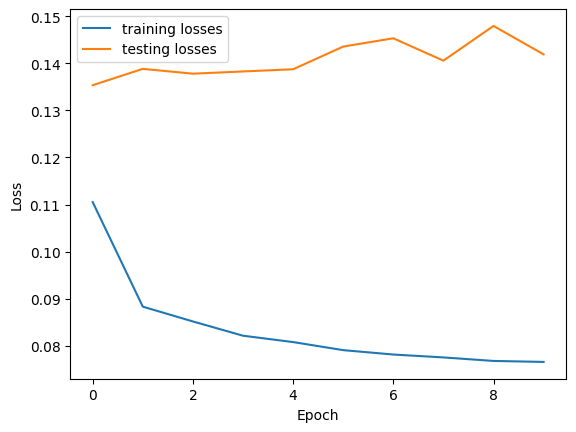


Final Training results:
Predicted num fractures: 521,    true num fractures: 569
Accuracy = 89.35%
Precision = 78.45%
Recall = 76.42%
F1 = 77.38%

Final Testing results:
Predicted num fractures: 205,    true num fractures: 603
Accuracy = 82.21%
Precision = 49.92%
Recall = 49.97%
F1 = 48.67%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


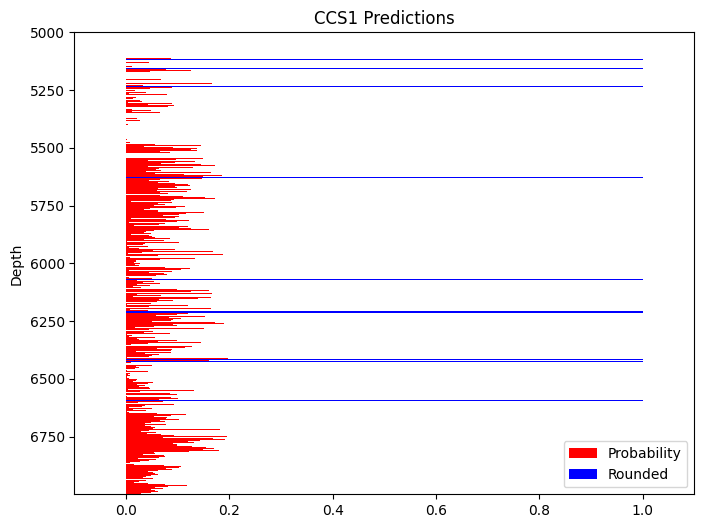

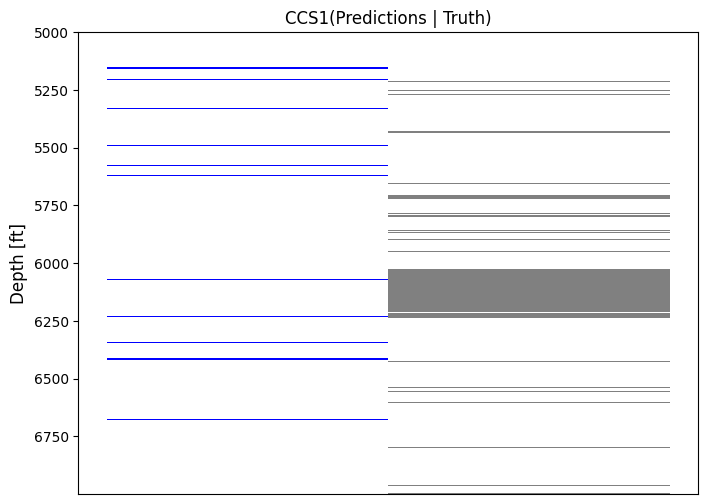


Training on ['CCS1'],  testing on VW1
Number of inputs: 22

Epoch - 0

Train:
Predicted num fractures: 1251,    true num fractures: 603
Accuracy = 74.96%
Precision = 62.51%
Recall = 71.3%
F1 = 63.5%

Test:
Predicted num fractures: 1295,    true num fractures: 569
Accuracy = 61.34%
Precision = 48.56%
Recall = 47.41%
F1 = 45.93%


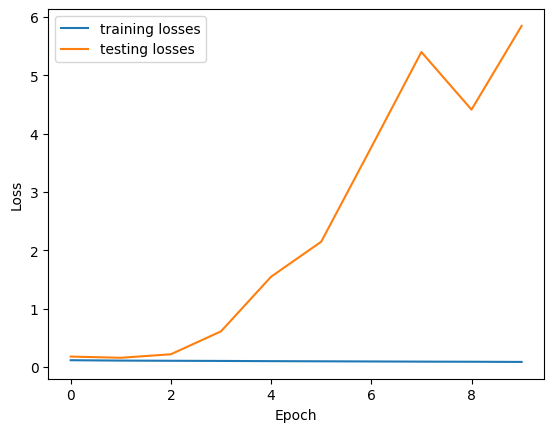


Final Training results:
Predicted num fractures: 962,    true num fractures: 603
Accuracy = 83.52%
Precision = 70.03%
Recall = 78.78%
F1 = 72.74%

Final Testing results:
Predicted num fractures: 90,    true num fractures: 569
Accuracy = 86.07%
Precision = 71.71%
Recall = 53.91%
F1 = 53.94%


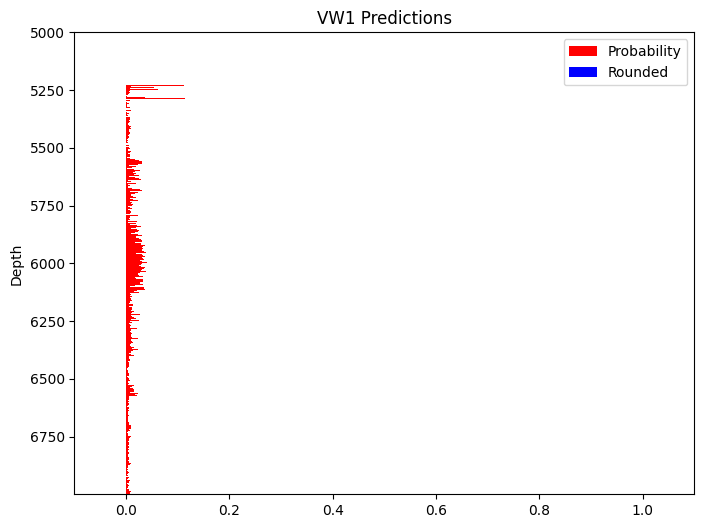

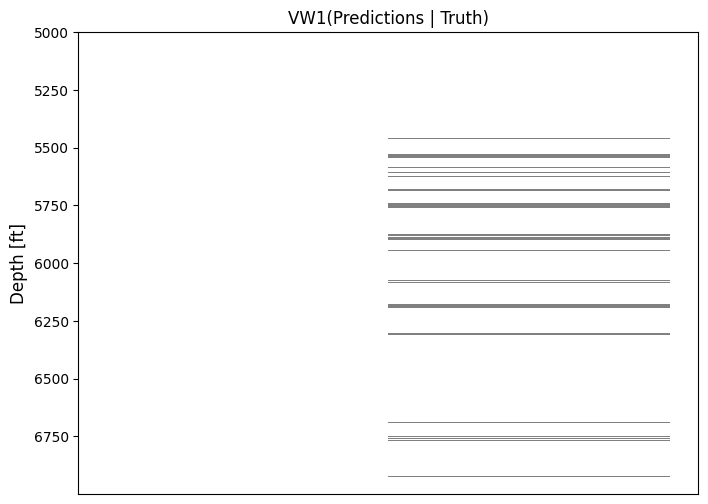

In [34]:
### run on gpu if you can to go faster
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  test = datasets[curr_well]
  trains = [datasets[well] for well in WELLS if well != curr_well]
  train = pd.concat(trains)
  test_depths = np.array(test["DEPT"])

  ### optional undersampling of majority class
  #train = balance_dataset(train)

  train_data = np.array(train.drop(columns=["HAS_FRAC", "DEPT", "FORM"], axis=1))
  train_labels = np.array(train["HAS_FRAC"])
  test_data = np.array(test.drop(columns=["HAS_FRAC", "DEPT", "FORM"], axis=1))
  test_labels = np.array(test["HAS_FRAC"])

  ### optional data preprocessing steps
  train_data, test_data = normalize(train_data, test_data)
  #train_data, test_data = apply_PCA(train_data, test_data)

  ### make custom datasets to feed into dataloader
  n_components = train_data.shape[1]
  trainset = CustomDataset(train_data, train_labels)
  testset = CustomDataset(test_data, test_labels)

  ### make dataloader objects that work with Pytorch
  train_dataloader = torch.utils.data.DataLoader(trainset,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)
  test_dataloader = torch.utils.data.DataLoader(testset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

  ### train/test model and display results
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
  testing on {curr_well}")

  train_test_loop(curr_well, train_dataloader, test_dataloader, n_components,
                                                                   verbose=True)
  print("\nFinal Training results:")
  evaluate_performance(curr_well, train_dataloader, True)
  print("\nFinal Testing results:")
  evaluate_performance(curr_well, test_dataloader, True, test_depths)